Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 24-May-2025

In [1]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

In [19]:
# Load dataset
file_name = 'hook_flexion_03_bdn2.parquet'
#file_name = 'pmt_control.parquet'
sampling_rate = 8.01 # Hz

data_path = r'../data'
file_path = os.path.join(data_path,file_name)
df = pd.read_parquet(file_path, engine='pyarrow')

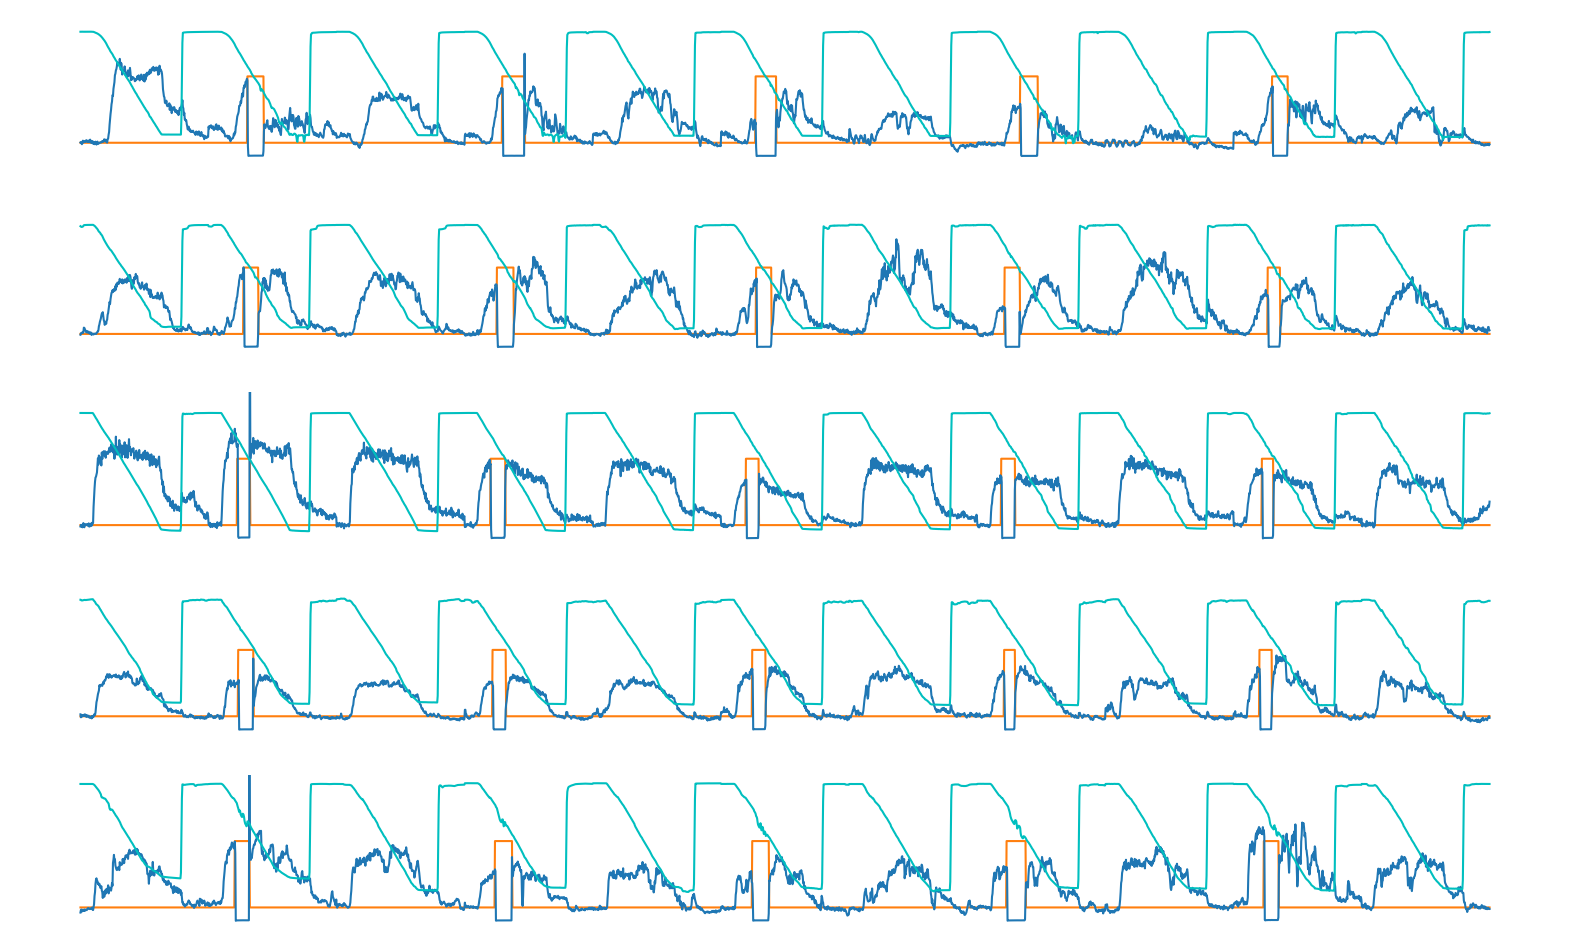

In [20]:
# Plot all data 
animal_ids = [1,2,3,4,5]
#animal_ids = [1,2,3]

# Initialize figure
fig, axs = plt.subplots(len(animal_ids),1, figsize=(20,12))

# Loop over animals
for animal_index, animal_id in enumerate(animal_ids):
    # Initialize variables
    stimulus = df.stimulus[df.animal_id==animal_id]
    calcium = df.calcium[df.animal_id==animal_id]
    if 'L1C_flex' in df.columns:
        angle = df.L1C_flex[df.animal_id==animal_id]

    ax1 = axs[animal_index] 
    ax1.plot(stimulus*5, color='#ff7f0e')
    ax1.plot(calcium, color='#1f77b4')
    ax1.set_ylim([-2,10])
    ax1.axis('off')
    if 'L1C_flex' in df.columns:
        ax2 = ax1.twinx()
        ax2.plot(angle,'c')
        ax2.set_ylim([0,180])
        ax2.axis('off')

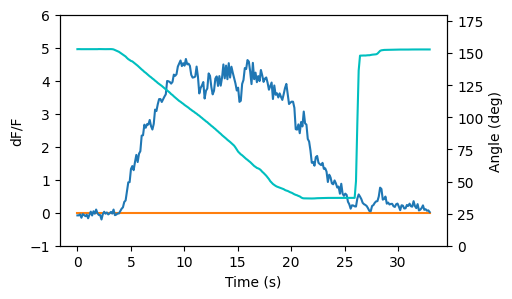

In [5]:
# Plot data of specific trial
animal_id = 2
trial = 3

calcium = df.calcium[(df.animal_id==animal_id) & (df.trial==trial)].to_numpy()
stimulus = df.stimulus[(df.animal_id==animal_id) & (df.trial==trial)].to_numpy()
time = df.time[(df.animal_id==animal_id) & (df.trial==trial)].to_numpy()
if 'L1C_flex' in df.columns:       
    angle = df.L1C_flex[(df.animal_id==animal_id) & (df.trial==trial)].to_numpy()

fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot(time, stimulus*5, color='#ff7f0e')
ax.plot(time, calcium, color='#1f77b4')
ax.set_ylim([-1,6])
ax.set_xlabel('Time (s)')
ax.set_ylabel('dF/F')
if 'L1C_flex' in df.columns:
    ax2 = ax.twinx()
    ax2.plot(time, angle,'c')
    ax2.set_ylim([0,180])
    ax2.set_ylabel('Angle (deg)')

In [21]:
# Compute mean stimulus duration

# BDN2 dataset
animal_ids = [1,2,3,4,5]
trials = [2,4,6,8,10]

# Control dataset
#animal_ids = [1,2,3]
#trials = [1,2,3,4,5,6,7,8,9,10,11,12]

# Initialize variables
stimulus_duration = []

# Loop over animals
for animal_index, animal_id in enumerate(animal_ids):

    # Loop over trials
    for trial_index, trial in enumerate(trials):
        frames = int(df.stimulus[(df.animal_id==animal_id) & (df.trial==trial)].sum())
        stimulus_duration.append(frames*1/sampling_rate)       

print(np.mean(stimulus_duration))
print(np.std(stimulus_duration))

3.98501872659176
0.6999460146572034


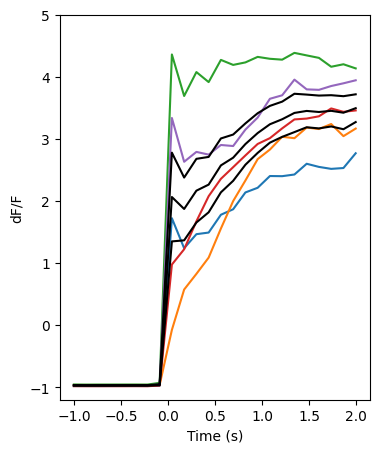

In [22]:
# Align data to stimulus offset 

# BDN2 dataset
animal_ids = [1,2,3,4,5] 
trials = [2,4,6,8,10]
#trials = [3,5,7,9,11]
stimulus_trials = [2,4,6,8,10]

# Control dataset
#animal_ids = [1,2,3] 
#trials = [1,2,3,4,5,6,7,8,9,10,11,12]
#stimulus_trials = trials

window_time = 3 # s 
pre_time = 1 # s

# Initialize variables 
window_frames = int(np.round(window_time*sampling_rate))
pre_frames = int(np.round(pre_time*sampling_rate))
calcium_all = np.zeros((window_frames,len(animal_ids)))
angle_all = np.zeros((window_frames,len(animal_ids)))

# Loop over animals
for animal_index, animal_id in enumerate(animal_ids):
    # Initialize variables
    calcium_animal = np.zeros((window_frames,len(trials)))
    angle_animal = np.zeros((window_frames,len(trials)))
    
    # Loop over trials
    for trial_index, trial in enumerate(trials):
        calcium = df.calcium[(df.animal_id==animal_id) & (df.trial==trial)].to_numpy()
        time = df.time[(df.animal_id==animal_id) & (df.trial==trial)].to_numpy()
       
        if 'L1C_flex' in df.columns:
            angle = df.L1C_flex[(df.animal_id==animal_id) & (df.trial==trial)].to_numpy()
        else:
            angle = np.zeros((len(time)))
        
        if trial in stimulus_trials: 
            # Stimulus trial
            stimulus = df.stimulus[(df.animal_id==animal_id) & (df.trial==trial)].to_numpy() 
        else:
            # For control trials of BDN2 dataset, take time point of preceding stimulus trial
            stimulus = df.stimulus[(df.animal_id==animal_id) & (df.trial==trial-1)].to_numpy()            
        
        # Align traces to stimulus offset
        onset = int(np.argwhere(np.diff(stimulus)<0)[0][0])
        onset = onset - pre_frames
        offset = onset + window_frames
        
        calcium = calcium[onset:offset]
        stimulus = stimulus[onset:offset]
        angle = angle[onset:offset]
        time = time[onset:offset]
        time = time-time[0]      
    
        calcium_animal[:,trial_index] = calcium
        angle_animal[:,trial_index] = angle

    calcium_all[:,animal_index] = np.mean(calcium_animal,axis=1)
    angle_all[:,animal_index] = np.mean(angle_animal,axis=1)

fig, ax = plt.subplots(figsize=(4,5))
time = np.linspace(0,np.size(calcium_all,axis=0)/sampling_rate,np.size(calcium_all,axis=0)) - pre_time
plt.plot(time,calcium_all)
mean = np.mean(calcium_all,axis=1)
sem = np.std(calcium_all,axis=1) / np.sqrt(np.size(calcium_all,axis=1))
plt.plot(time,mean,'k')
plt.plot(time,mean+sem,'k')
plt.plot(time,mean-sem,'k')
plt.ylim([-1.2,5])
plt.xlabel('Time (s)')
plt.ylabel('dF/F')
plt.show()

In [9]:
delta_calcium_exp = calcium_all[-1,:] - calcium_all[pre_frames+1,:]

In [11]:
delta_calcium_control = calcium_all[-1,:] - calcium_all[pre_frames+1,:]

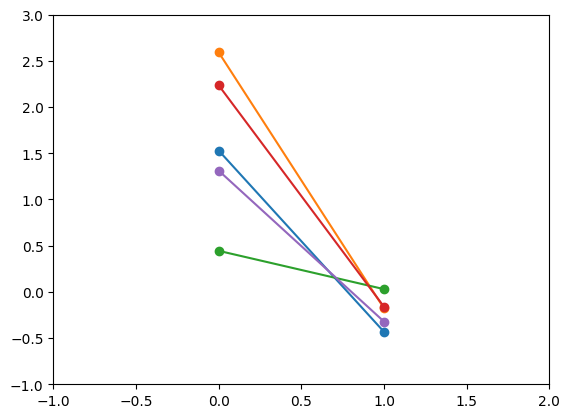

In [12]:
# Plot change in calcium
plt.plot([np.zeros((5)), np.zeros((5))+1], [delta_calcium_exp, delta_calcium_control],'-o')
plt.ylim([-1,3])
plt.xlim([-1,2])
plt.show()

In [13]:
# Compare change in calcium
ttest_rel(delta_calcium_exp,delta_calcium_control)

TtestResult(statistic=np.float64(4.5429317861724305), pvalue=np.float64(0.01047372513781019), df=np.int64(4))